In [1]:
# Hanxiao Wu
# GT username: hwu429

import numpy as np
import pandas as pd
import gym

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
#torch.manual_seed(0)
#np.random.seed(0)

In [230]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# a larger net
class Net(nn.Module):
    def __init__(self, n_states, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_states, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, n_actions)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = F.sigmoid(x)
        actions_value = self.out(x)
        return actions_value

def batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func, verbose=True):
    """
    Given a batch of experience tuple, train/update the eval_model.
    X: Q(state, action, w_eval)
    y: r + max(Q(state', action', w_target))
    """
      
    if len(D) < batch_size:
        return 
    
    D_sampled = D[np.random.choice(D.shape[0], batch_size, replace=True)]
    
    ## get a batch of experience tuples
    state_list, action_list, target_list = np.zeros((0,8)), np.zeros((0,1)), np.zeros((0,1))
    for state, action, state_prime, reward, done in D_sampled:
        if not done:
            y_target = reward + gamma * (max(target_model(torch.from_numpy(np.array(state_prime)).float()))).data.numpy()
        else: 
            y_target = reward
        state_list = np.append(state_list, [state], axis=0)
        action_list = np.append(action_list, [[action]], axis=0)
        target_list = np.append(target_list, [[y_target]], axis=0)

    ## batch training 
    x = torch.from_numpy(state_list).float()
    action_list_batch = torch.from_numpy(action_list.astype('int64'))
    action_mask = torch.from_numpy(np.eye(4)[action_list_batch.numpy()].squeeze()) ## the optimal action

    y_target = torch.from_numpy(target_list).float()*action_mask ## state, action taken
    y_pred = eval_model(x)*action_mask ## state, action taken
    
    if loss_func =='l2':
        loss = loss_fn(y_pred, y_target) 
    elif loss_func =='huber':
        loss = F.smooth_l1_loss(y_pred, y_target)
    
    if verbose and t % C == 0:
        print(t, loss.item())
        print('eval model weight updated')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

In [3]:
def get_experience(eval_model, state, epsilon):
    
    y_pred = eval_model(torch.from_numpy(np.array(state)).float()) ## 4 actions
    opt_action = np.argmax(y_pred.detach()).numpy()
    action = [np.random.randint(0, n_actions) if np.random.random() < epsilon else opt_action][0]
    state_prime, reward, done, info = env.step(action)
    
    return state, action, state_prime, reward, done

def target_model_update(target_model, eval_model, tau):

    params_eval = eval_model.named_parameters()
    params_target = target_model.named_parameters()
    dict_params_target = dict(params_target)

    for name_eval, param_eval in params_eval:
        if name_eval in dict_params_target:
            dict_params_target[name_eval].data.copy_(tau * param_eval.data + (1-tau) * dict_params_target[name_eval].data )

    target_model.load_state_dict(dict_params_target)

def model_initialize():
    
    eval_model = Net(D_in,D_out).to(device)
    target_model = Net(D_in,D_out).to(device)
    target_model.load_state_dict(eval_model.state_dict()) ## update target model as eval model

    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.RMSprop(eval_model.parameters(), lr=learning_rate)
    return eval_model, target_model, loss_fn, optimizer

In [4]:
## Q learning

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 8, 64, 4

n_actions = 4
n_state_features = 8

D_max_length = 200000
max_steps = 1000 
C = 4 ## target model update freq
batch_size = 64
tau = 0.001

gamma = 0.99
learning_rate = 0.0008
epsilon = 1 
edr = 0.995
epsilon_min = 0.01

n_episodes = 801

In [48]:
np.random.seed(0)

env = gym.make("LunarLander-v2").env

## initialize Q function with random weights, initialze D
eval_model, target_model, loss_fn, optimizer = model_initialize()

D = np.zeros((0,5)) ## replay data 
full_D = np.zeros((0,6)) ## replay data 
R_list = []
epsilon = 1

for i in range(n_episodes): 
    env.seed(i)
    state = env.reset()
    R = 0
    epsilon = max(epsilon*edr, epsilon_min) 
    
    for t in range(max_steps): 
        #env.render()
        
        ## get action and excute, get experience tuple
        state, action, state_prime, reward, done = get_experience(eval_model, state, epsilon)
         
        ## record reward
        R += reward 
        
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]
        full_D = np.append(full_D, [[state, action, state_prime, reward, done, i]], axis=0)
        
        if t % C == 0:
            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            
            ## soft update target model
            target_model_update(target_model, eval_model, tau)
            
        ## go to the next state
        state = state_prime 
        
        if done:
            break
            
    #env.close()
    R_list.append(R)
    
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
              i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))

episode 0, current_reward -93.6809, reward_rolling_mean -93.6809, epsilon 0.995, buffer_size 102
episode 50, current_reward -96.129, reward_rolling_mean -167.4033, epsilon 0.7744, buffer_size 4889
episode 100, current_reward -145.176, reward_rolling_mean -173.9195, epsilon 0.6027, buffer_size 11123
episode 150, current_reward -45.6552, reward_rolling_mean -141.5792, epsilon 0.4691, buffer_size 22315
episode 200, current_reward -129.208, reward_rolling_mean -85.1408, epsilon 0.3651, buffer_size 38257
episode 250, current_reward 23.0556, reward_rolling_mean -82.3483, epsilon 0.2842, buffer_size 61322
episode 300, current_reward 200.3724, reward_rolling_mean -64.6213, epsilon 0.2212, buffer_size 102602
episode 350, current_reward -3.0956, reward_rolling_mean -16.8145, epsilon 0.1721, buffer_size 150401
episode 400, current_reward -85.6731, reward_rolling_mean 10.6683, epsilon 0.134, buffer_size 191625
episode 450, current_reward 199.3069, reward_rolling_mean 57.3006, epsilon 0.1043, buffe

KeyboardInterrupt: 

In [233]:
for i in range(801, 2000): 
    env.seed(i)
    state = env.reset()
    R = 0
    epsilon = max(epsilon*edr, epsilon_min) 
    
    for t in range(max_steps): 
        #env.render()
        
        ## get action and excute, get experience tuple
        state, action, state_prime, reward, done = get_experience(eval_model, state, epsilon)
         
        ## record reward
        R += reward 
        
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]
        full_D = np.append(full_D, [[state, action, state_prime, reward, done, i]], axis=0)
        
        if t % C == 0:
            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            
            ## soft update target model
            target_model_update(target_model, eval_model, tau)
            
        ## go to the next state
        state = state_prime 
        
        if done:
            break
            
    #env.close()
    R_list.append(R)
    
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
              i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))

episode 850, current_reward 239.115, reward_rolling_mean 199.7456, epsilon 0.014, buffer_size 200000
episode 900, current_reward 255.579, reward_rolling_mean 191.1808, epsilon 0.0109, buffer_size 200000
episode 950, current_reward -9.9467, reward_rolling_mean 179.1291, epsilon 0.01, buffer_size 200000
episode 1000, current_reward 266.6526, reward_rolling_mean 200.5472, epsilon 0.01, buffer_size 200000
episode 1050, current_reward 297.8516, reward_rolling_mean 235.5881, epsilon 0.01, buffer_size 200000
episode 1100, current_reward 253.7162, reward_rolling_mean 248.9292, epsilon 0.01, buffer_size 200000
episode 1150, current_reward 254.4886, reward_rolling_mean 251.4138, epsilon 0.01, buffer_size 200000
episode 1200, current_reward -94.6411, reward_rolling_mean 250.1221, epsilon 0.01, buffer_size 200000
episode 1250, current_reward 303.7665, reward_rolling_mean 240.3995, epsilon 0.01, buffer_size 200000
episode 1300, current_reward 265.367, reward_rolling_mean 247.1186, epsilon 0.01, buf

In [257]:
df_Q = pd.DataFrame(full_D)
df_Q.columns=['state','action','next_state','reward','done','episode']
#df_Q['done_cumsum'] = df_Q['done'].cumsum()
df_Q = df_Q.loc[(df_Q.episode>405)]
df_Q = df_Q.loc[(df_Q.episode!=707)]
df_Q.loc[df_Q.episode>707, 'episode']=df_Q.loc[df_Q.episode>707, 'episode']-1


### reward should be discounted by gamma = 0.99

df_D=df_Q.copy()
df_D['step'] = df_D.groupby('episode')['reward'].cumcount()#['reward'].transform(lambda x: x*gamma)
df_D['discounted_reward'] = df_D['reward'] * (gamma **df_D['step'])

df_D = df_D[['state', 'action', 'next_state', 'reward', 'done', 'episode','step','discounted_reward']].copy()

df_R = pd.DataFrame(df_D.groupby(['episode'])['discounted_reward'].sum()).reset_index()
df_R.columns=['episode','total_reward']

df_D = df_D.merge(df_R, on='episode', how='left')

df_D['episode_cum_reward'] = df_D.groupby(['episode'])['discounted_reward'].transform(lambda x: x.cumsum())
df_D['target'] = df_D['total_reward'] - df_D['episode_cum_reward']

df_selected = df_D.loc[df_D.episode>=1100].groupby('episode').head(1) #
df_selected2=df_D.loc[df_D.episode>=1950]

In [255]:
def get_model_perf(df):
    state_list, action_list, target_list, total_reward_list = np.zeros((0,8)), np.zeros((0,1)), np.zeros((0,1)), np.zeros((0,1))
    for index, row in df.iterrows():
        state, action, total_reward = row['state'], row['action'], row['target']
        y_target = total_reward
        state_list = np.append(state_list, [state], axis=0)
        action_list = np.append(action_list, [[action]], axis=0)
        target_list = np.append(target_list, [[y_target]], axis=0)

    ## batch training 
    x = torch.from_numpy(state_list).float()
    action_list_batch = torch.from_numpy(action_list.astype('int64'))
    action_mask = torch.from_numpy(np.eye(4)[action_list_batch.numpy()].squeeze()) ## the optimal action

    y_target = torch.from_numpy(target_list).float()*action_mask ## state, action taken
    y_pred = eval_model(x)*action_mask ## state, action taken


    l2_loss = loss_fn(y_pred, y_target) 

    y_test = y_target.sum(axis=1).detach().numpy()
    y_test_pred = y_pred.sum(axis=1).detach().numpy()

    mse = mean_squared_error(y_test, y_test_pred)
    r_square = r2_score(y_test, y_test_pred)
    print(mse, r_square)

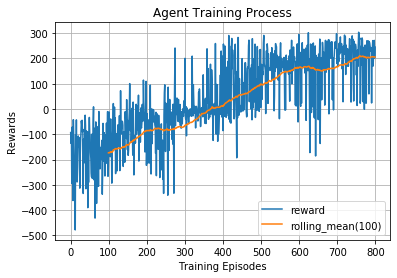

In [224]:
plt.plot(pd.Series(R_list), label='reward')
plt.plot(pd.Series(R_list).rolling(100).mean(), label='rolling_mean(100)')

plt.title('Agent Training Process')
plt.xlabel('Training Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
#plt.savefig('fig1.png')
#plt.clf()

In [ ]:
for i in range(801, 2000): 
    env.seed(i)
    state = env.reset()
    R = 0
    epsilon = max(epsilon*edr, epsilon_min) 
    
    for t in range(max_steps): 
        #env.render()
        
        ## get action and excute, get experience tuple
        state, action, state_prime, reward, done = get_experience(eval_model, state, epsilon)
         
        ## record reward
        R += reward 
        
        ## save tuple to D
        D = np.append(D, [[state, action, state_prime, reward, done]], axis=0)[-D_max_length:]
        full_D = np.append(full_D, [[state, action, state_prime, reward, done, i]], axis=0)
        
        if t % C == 0:
            ## model: update eval model
            batch_training(D, batch_size, eval_model, target_model, learning_rate, loss_func='l2', verbose=False) 
            
            ## soft update target model
            target_model_update(target_model, eval_model, tau)
            
        ## go to the next state
        state = state_prime 
        
        if done:
            break
            
    #env.close()
    R_list.append(R)
    
    if i % 50 == 0:
        print("episode {}, current_reward {}, reward_rolling_mean {}, epsilon {}, buffer_size {}".format(
              i, round(R,4), round(np.mean(R_list[-100:]),4), round(epsilon,4), len(D)))

In [252]:
## testing episode for 100

test_D = np.zeros((0,6)) ## replay data 
env = gym.make("LunarLander-v2").env
env.seed(5)
test_R_list = []
for i in range(200): 
    state = env.reset()
    R = 0
    for t in range(1000): 
        #env.render()
        
        ## get action and excute, get experience tuple
        state, action, state_prime, reward, done = get_experience(eval_model, state, epsilon)
         
        ## record reward
        R += reward 
        
        ## save tuple to D
        test_D = np.append(test_D, [[state, action, state_prime, reward, done, i]], axis=0)
        
        ## move to next step
        state=state_prime
        if done:
            break
    print(i, R, t, np.mean(test_R_list[-50:]))
    test_R_list.append(R)
    
#env.close()    

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 288.0618613559685 241 nan
1 138.66873087719623 999 288.0618613559685
2 285.60894420494583 219 213.36529611658239
3 239.66293004648068 265 237.44651214603687
4 273.09467077182364 172 238.00061662114783
5 287.85624845129325 264 245.01942745128298
6 211.66291890382894 197 252.15889761795134
7 296.52651838430745 235 246.37375780164817
8 150.3780670529016 999 252.64285287448058
9 270.6234285352587 249 241.28009889430515
10 140.54229568428198 999 244.21443185840053
11 291.2941381289055 220 234.78969220620795
12 290.600250806983 248 239.49839603309943
13 263.3731146097076 236 243.42930793878278
14 243.5886346821752 325 244.85386555813457
15 306.1166125890634 249 244.7695168330706
16 236.97639429703207 180 248.6037103178201
17 297.7490323001402 249 247.91975055189135
18 282.58456353359213 229 250.68804398234963
19 299.7103068303454 233 252.3668081692571
20 -21.335018620531073 122 254.7339831023115
21 231.2725151514195 173 241.58784016312853
22 278.60512232610614 301 241.1189617535054
23 235.

184 308.8845728938545 202 230.4505866013343
185 103.80967582161368 999 231.79002708613854
186 272.4693182210187 146 228.09246774246571
187 288.79738338627755 244 228.79247992871714
188 282.8901562793534 197 229.30712501718696
189 238.43143676409588 152 230.13046382388566
190 6.812852224252836 131 235.24459052334166
191 269.4360962155431 186 230.7290318174073
192 -6.066427763366704 135 231.27080675289858
193 277.7328880071915 255 226.7698587264882
194 116.79356598396097 999 228.15912659043238
195 189.85518781752643 795 230.704786905927
196 209.7929648004977 791 229.13033622181536
197 247.87497396933264 183 227.82501579026157
198 239.3101832632919 260 226.9948714615201
199 224.86433693201928 309 226.81489285392274


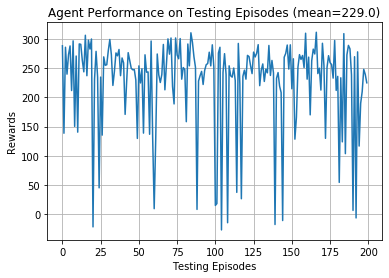

In [253]:
plt.plot(pd.Series(test_R_list))
plt.title('Agent Performance on Testing Episodes (mean={})'.format(round(np.mean(test_R_list)),1))
plt.xlabel('Testing Episodes')
plt.ylabel('Rewards')
plt.grid()
#plt.savefig('fig2.png')
#plt.clf()

In [254]:
df_Q = pd.DataFrame(test_D)
df_Q.columns=['state','action','next_state','reward','done','episode']
#df_Q['done_cumsum'] = df_Q['done'].cumsum()

### reward should be discounted by gamma = 0.99

df_D=df_Q.copy()
df_D['step'] = df_D.groupby('episode')['reward'].cumcount()#['reward'].transform(lambda x: x*gamma)
df_D['discounted_reward'] = df_D['reward'] * (gamma **df_D['step'])

df_D = df_D[['state', 'action', 'next_state', 'reward', 'done', 'episode','step','discounted_reward']].copy()

df_R = pd.DataFrame(df_D.groupby(['episode'])['discounted_reward'].sum()).reset_index()
df_R.columns=['episode','total_reward']

df_D = df_D.merge(df_R, on='episode', how='left')

df_D['episode_cum_reward'] = df_D.groupby(['episode'])['discounted_reward'].transform(lambda x: x.cumsum())
df_D['target'] = df_D['total_reward'] - df_D['episode_cum_reward']

df_selected = df_D.groupby('episode').head(1) #
#df_selected2=df_D.loc[df_D.episode>=1950]

In [256]:
get_model_perf(df_selected)

279.8340823982708 0.3057779071983854


In [258]:
get_model_perf(df_selected) ## 1100

163.41097309855022 0.49682107050340996


In [277]:
def save_weights(eval_net,target_net, weight_name="20201105_weights", model_name="20201105_model"):
    torch.save(eval_net.state_dict(), os.path.join("{}_eval_net".format(weight_name)))
    torch.save(target_net.state_dict(), os.path.join("{}_target_net".format(weight_name)))
    torch.save(eval_net, os.path.join("{}_eval_net".format(model_name)))
    torch.save(target_net, os.path.join("{}_target_net".format(model_name)))

In [278]:
import os
save_weights(eval_model,target_model, weight_name="20201105_weights", model_name="20201105_model")

In [279]:
eval_model(x)*action_mask

tensor([[ 0.0000, 55.5498,  0.0000,  0.0000],
        [ 0.0000, 44.1338,  0.0000,  0.0000],
        [ 0.0000, 67.3602,  0.0000,  0.0000],
        ...,
        [77.7472,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 50.7462],
        [ 0.0000, 54.0094,  0.0000,  0.0000]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [280]:
weight_name="20201105_weights"
model_name="20201105_model"
PATH = os.path.join("{}_eval_net".format(model_name))#os.path.join("{}_eval_net".format(weight_name))

In [281]:
model = torch.load(PATH)
model.eval()

model(x)*action_mask

tensor([[ 0.0000, 55.5498,  0.0000,  0.0000],
        [ 0.0000, 44.1338,  0.0000,  0.0000],
        [ 0.0000, 67.3602,  0.0000,  0.0000],
        ...,
        [77.7472,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 50.7462],
        [ 0.0000, 54.0094,  0.0000,  0.0000]], dtype=torch.float64,
       grad_fn=<MulBackward0>)